In [ ]:
from google.colab import drive
import os

#set cwd
drive.mount('/content/drive', force_remount = True)

cwd = '/content/drive/MyDrive/hyperspectral_denoising'
os.chdir(cwd)

print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/hyperspectral_denoising


In [ ]:
!pip install scikit-image
!pip install spectral

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
import numpy as np
from torch.utils.data.dataset import Dataset
from spectral import imshow, save_rgb
import sys
import matplotlib.pyplot as plt

In [ ]:
#taken as is from ./destriping/data/loader.py
class HyperSpectralCube(Dataset):
    def __init__(self, mat_path, label="paviaU"):
        data = scipy.io.loadmat(mat_path)[label]
        data = np.float32(data)
        self.cube = data
        data = np.moveaxis(data, -1, 0)
        self.images = torch.from_numpy(data)
        self.bands = len(self.images)

    def __getcube__(self):
        return self.images

    def __getitem__(self, band):
        x = self.images[band]
        return x

    def __len__(self):
        return self.bands

    def plot(self, band, save_to = None, show = False):
        imshow(self.cube, [band])
        if save_to:
            save_rgb(save_to, self.cube, [band])
            if show:
                plt.imshow(self.images[band])
                plt.show()
        return

In [ ]:
def calc_psnr(output_image, ground_truth):
    #loading images
    output_image = io.imread(output_image)
    ground_truth = io.imread(ground_truth)

    #ensure both images have same size and data type
    if output_image.shape != ground_truth.shape or output_image.dtype != ground_truth.dtype:
        raise ValueError("Images must have the same shape and data type.")

    psnr_value = peak_signal_noise_ratio(output_image, ground_truth)

    print(f"PSNR: {psnr_value:.2f} dB")

    return psnr_value

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_channels, latent_dim):
    super(Encoder, self).__init__()

    #encoder layers
    self.conv3d_1 = nn.Conv3d(input_channels, 16, kernel_size = 3, stride = 1, padding = 1)
    self.conv3d_2 = nn.Conv3d(16, 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3d_3 = nn.Conv3d(32, latent_dim, kernel_size = 3, stride = 1, padding = 1)
    # self.conv3d_4 = nn.Conv3d(64, latent_dim, kernel_size = 3, stride = 1, padding = 2)
    self.max_pool = nn.MaxPool3d(kernel_size = 3, stride = 1, padding = 1)

  def forward(self, x):
    x = self.conv3d_1(x)
    x = F.relu(x)
    x = self.max_pool(x)
    x = self.conv3d_2(x)
    x = F.relu(x)
    x = self.max_pool(x)
    x = self.conv3d_3(x)
    x = F.relu(x)
    x = self.max_pool(x)
    # x = self.conv3d_4(x)

    return x

In [ ]:
class Decoder(nn.Module):
  def __init__(self, input_channels, output_dim):
    super(Decoder, self).__init__()

    #decoder layers
    self.conv3d_1 = nn.Conv3d(input_channels, 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3d_2 = nn.Conv3d(32, 64, kernel_size = 3, stride = 1, padding = 1)
    self.conv3d_3 = nn.Conv3d(64, output_dim, kernel_size = 1, stride = 1, padding = 0)

  def forward(self, x):
    x = self.conv3d_1(x)
    x = self.conv3d_2(x)
    x = self.conv3d_3(x)

    return x

Length of dataset = 103


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


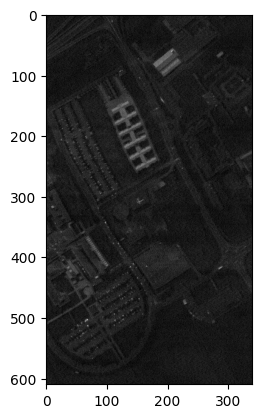

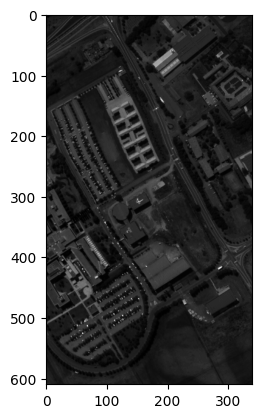

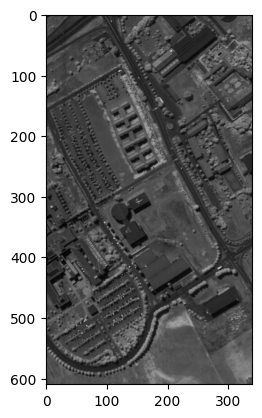

In [ ]:
#lets try some stuff so far
data_cube_path = "PaviaU.mat"
hyper_dataset = HyperSpectralCube(data_cube_path, "paviaU")
print(f"Length of dataset = {hyper_dataset.__len__()}")
hyper_dataset.plot(0, show = True)
hyper_dataset.plot(40, show = True)
hyper_dataset.plot(100, show = True)

In [ ]:
# data_cube = hyper_dataset.__getcube__()
# print(f"Original shape = {data_cube.shape}")

# #slicing tensor because google colab RAM runs out
# sliced_data_cube = data_cube[:, 0:100, 0:100]
# print(f"Sliced shape = {sliced_data_cube.shape}")

# #need to reshpae the data cube to match (1, 3, *data_cube.shape) #(batch size, input_channels, spectral resolution, *spacial resolution)
# data_cube = sliced_data_cube.unsqueeze(0).unsqueeze(1)
# print(f"Reshaped shape = {data_cube.shape}")


# encoder = Encoder(input_channels = 1, latent_dim = 64)
# feature_F = encoder(data_cube)
# print(f"Encoder output shape = {feature_F.shape}")

In [ ]:
class SpatialDirectionAwareConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SpatialDirectionAwareConvBlock, self).__init__()

        #vertical
        self.vertical_conv3d_1 = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 1, 3), padding = (1, 0, 1))

        #horizontal
        self.horizontal_conv3d_1 = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 1), padding = (1, 1, 0))

        #main-diagonal
        #need to create a diagonal identity matrix
        kernel = torch.eye(3).unsqueeze(0).unsqueeze(0)
        main_diag_identity = torch.eye(3).unsqueeze(0).unsqueeze(0)
        self.main_diag_conv = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 3), padding = (1, 1, 1))
        self.main_diag_conv.weight.data = torch.nn.functional.conv3d(kernel, main_diag_identity, padding=(1, 1, 1))

        #anti-diagonal
        anti_diag_identity = torch.eye(3).flip([-1]).unsqueeze(0).unsqueeze(0)
        self.anti_diag_conv = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 3), padding = (1, 1, 1))
        self.anti_diag_conv.weight.data = torch.nn.functional.conv3d(kernel.flip[-1], anti_diag_identity, padding = (1, 1, 1))

        #feature aggregation layer
        self.aggregate_conv3d = nn.Conv3d(4 * output_channels, output_channels, kernel_size = (1, 1, 1))

    def forward(self, x):
        #vertical
        x_vertical = self.vertical_conv3d_1(x)
        x_vertical = F.relu(x_vertical)

        #horizontal
        x_horizontal = self.horizontal_conv3d_1(x)
        x_horizontal = F.relu(x_horizontal)

        #main-diagonal
        x_main_diag = self.main_diag_conv3d_1(x)
        x_main_diag = F.relu(x_main_diag)

        #anti-diagonal
        x_anti_diag = self.anti_diag_conv3d_1(x)
        x_anti_diag = F.relu(x_anti_diag)

        #feature aggregation layer
        x = self.aggregate_conv3d(torch.cat([x_vertical, x_horizontal, x_main_diag, x_anti_diag], dim = 1))

        return x

In [ ]:
torch.eye(3).flip([-1]).unsqueeze(0).unsqueeze(0) == torch.eye(3).unsqueeze(0).unsqueeze(0).flip([-1])

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]]]])

In [ ]:
class SparsePyramidLikeConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SparsePyramidLikeConvBlock, self).__init__()

        #dialated conv: dilation controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.
        #source: https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#torch.nn.Conv3d
        # animation: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#dilated-convolution-animations

        self.dilated_conv3d_1 = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 3), dilation = (1, 1, 1), padding = (1, 1, 1))
        self.dilated_conv3d_2 = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 3), dilation = (2, 2, 2), padding = (2, 2, 2))
        self.dilated_conv3d_3 = nn.Conv3d(input_channels, output_channels, kernel_size = (3, 3, 3), dilation = (3, 3, 3), padding = (3, 3, 3))

        #feature aggregation layer
        self.aggregate_conv3d = nn.Conv3d(3 * output_channels, output_channels, kernel_size = (1, 1, 1))

    def forward(self, x):
        x_dilated1 = F.relu(self.dilated_conv3d_1(x))
        x_dilated2 = F.relu(self.dilated_conv3d_2(x))
        x_dilated3 = F.relu(self.dilated_conv3d_3(x))

        # Feature aggregation layer
        x = self.aggregate_conv3d(torch.cat([x_dilated1, x_dilated2, x_dilated3], dim=1))

        return x

In [ ]:
data_cube = hyper_dataset.__getcube__()
print(f"Original shape = {data_cube.shape}")

#slicing tensor because google colab RAM runs out
sliced_data_cube = data_cube[:, 0:100, 0:100]
print(f"Sliced shape = {sliced_data_cube.shape}")

#need to reshpae the data cube to match (1, 3, *data_cube.shape) #(batch size, input_channels, spectral resolution, *spacial resolution)
data_cube = sliced_data_cube.unsqueeze(0).unsqueeze(1)
print(f"Reshaped shape = {data_cube.shape}")


encoder = Encoder(input_channels = 1, latent_dim = data_cube.__len__())
stripe_att_estimator_p1 = SpatialDirectionAwareConvBlock(input_channels = data_cube.__len__(), output_channels = data_cube.__len__())
stripe_att_estimator_p2 = SparsePyramidLikeConvBlock(input_channels = data_cube.__len__(), output_channels = data_cube.__len__())


feature_F = encoder(data_cube)
print(f"feature_F shape = {feature_F.shape}")

M = stripe_att_estimator_p2(stripe_att_estimator_p1(data_cube))
print(f"M shape = {M.shape}")

Original shape = torch.Size([103, 610, 340])
Sliced shape = torch.Size([103, 100, 100])
Reshaped shape = torch.Size([1, 1, 103, 100, 100])
feature_F shape = torch.Size([1, 1, 103, 100, 100])
M shape = torch.Size([1, 1, 103, 100, 100])


In [ ]:
F_M = torch.cat((feature_F[:, None, :, :, :], M[:, None, :, :, :]), dim=1)
print(f"F_M shape = {F_M.shape}")


F_M shape = torch.Size([1, 2, 1, 103, 100, 100])
